In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Time series-specific libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats

from itertools import product
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

In [21]:
# Configure global settings for plots
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [6]:
# Define utility functions
def parse_date(dates):
    """
    Parse string dates into datetime objects.
    """
    return datetime.strptime(dates, '%Y-%m-%d')

def check_stationarity(series, title):
    """
    Perform the Dickey-Fuller test to check stationarity of a time series.
    """
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"{title} - Dickey-Fuller test p-value: {p_value:.6f}")
    return p_value < 0.05

def inverse_boxcox(y, lmbda):
    """
    Inverse Box-Cox transformation.
    """
    return np.exp(np.log(lmbda * y + 1) / lmbda) if lmbda != 0 else np.exp(y)

In [8]:
# Load and preprocess data
df = pd.read_csv('/content/crypto-markets.csv', parse_dates=['date'], index_col='date', date_parser=parse_date)
print("Data preview:")
display(df.head())

Data preview:


,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32


In [9]:
# Extract Bitcoin data and drop unnecessary columns
btc = df[df['symbol'] == 'BTC'].copy()
btc.drop(['slug', 'volume', 'symbol', 'name', 'ranknow', 'market', 'close_ratio', 'spread'], axis=1, inplace=True)
print("Bitcoin data after column selection:")
display(btc.head())

Bitcoin data after column selection:


,open,high,low,close
date,,,,
2013-04-28,135.30,135.98,132.10,134.21
2013-04-29,134.44,147.49,134.00,144.54
2013-04-30,144.00,146.93,134.05,139.00
2013-05-01,139.00,139.89,107.72,116.99
2013-05-02,116.38,125.60,92.28,105.21


In [10]:
# Resample to monthly frequency
btc_month = btc.resample('M').mean()
print(f"Resampled Bitcoin data (Monthly): {btc_month.shape[0]} rows")

Resampled Bitcoin data (Monthly): 68 rows



## Stationarity Check
Original Close Prices - Dickey-Fuller test p-value: 0.479017
Series is not stationary. Proceeding with transformations.



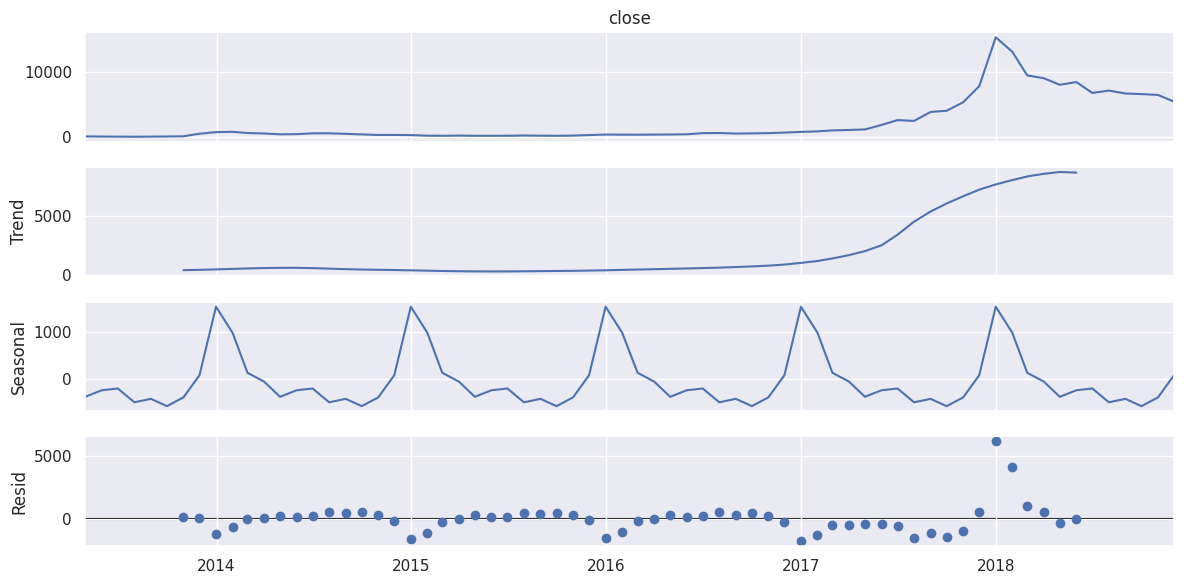

In [11]:
# Stationarity check
print("\n## Stationarity Check")
seasonal_decompose(btc_month['close']).plot()
stationary = check_stationarity(btc_month['close'], "Original Close Prices")
if not stationary:
    print("Series is not stationary. Proceeding with transformations.\n")

In [12]:
# Apply Box-Cox Transformation
print("\n## Box-Cox Transformation")
btc_month['close_box'], lmbda = stats.boxcox(btc_month['close'])
stationary = check_stationarity(btc_month['close_box'], "Box-Cox Transformed Close Prices")
if not stationary:
    print("Still not stationary. Proceeding with differencing.\n")


## Box-Cox Transformation
Box-Cox Transformed Close Prices - Dickey-Fuller test p-value: 0.479048
Still not stationary. Proceeding with differencing.



In [13]:
# Differencing to achieve stationarity
btc_month['close_diff'] = btc_month['close_box'] - btc_month['close_box'].shift(1)
stationary = check_stationarity(btc_month['close_diff'], "Differenced Close Prices")
if stationary:
    print("Differenced series is stationary. Ready for modeling.\n")

Differenced Close Prices - Dickey-Fuller test p-value: 0.000001
Differenced series is stationary. Ready for modeling.




## ACF and PACF Plots


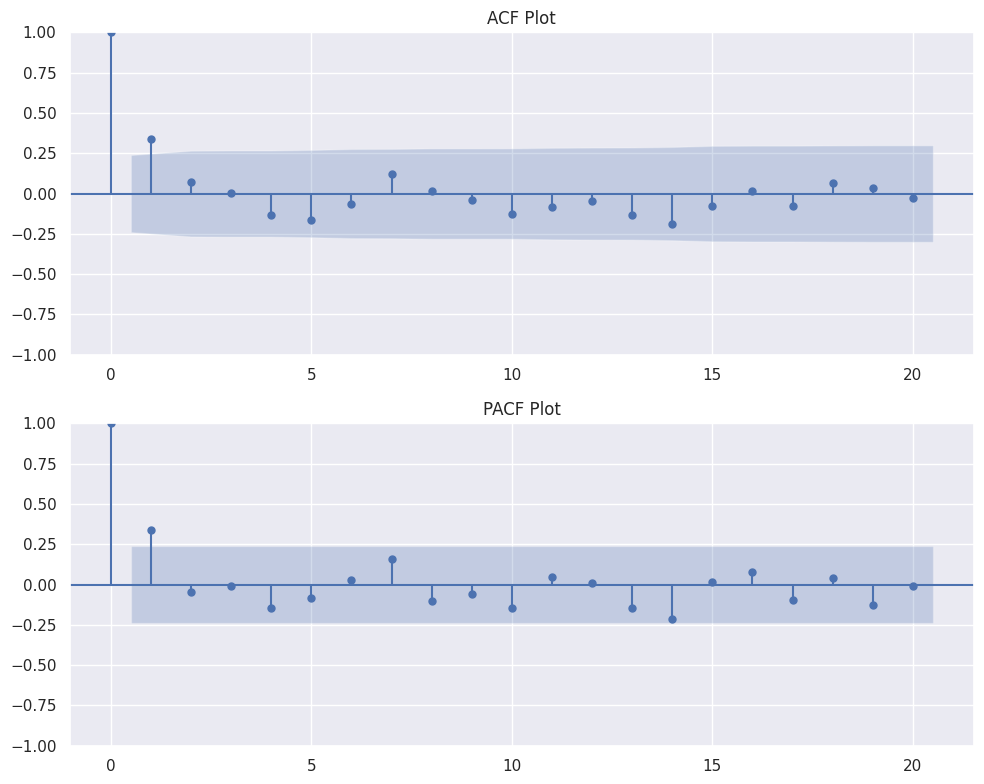

In [14]:
# Visualize ACF and PACF
print("\n## ACF and PACF Plots")
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(btc_month['close_diff'].dropna(), lags=20, ax=axes[0])
axes[0].set_title("ACF Plot")
plot_pacf(btc_month['close_diff'].dropna(), lags=20, ax=axes[1])
axes[1].set_title("PACF Plot")
plt.tight_layout()
plt.show()

In [15]:
# Parameter selection for ARIMA model
print("\n## ARIMA Model Parameter Selection")
p = q = range(0, 3)  # Parameter ranges for AR and MA terms
d = 1  # Degree of differencing
parameters = list(product(p, q))
best_aic = float("inf")
best_model = None


## ARIMA Model Parameter Selection


In [16]:
# Fit models with all parameter combinations
print("Evaluating parameter combinations...")
for param in parameters:
    try:
        model = SARIMAX(btc_month['close_box'], order=(param[0], d, param[1])).fit(disp=False)
        if model.aic < best_aic:
            best_aic = model.aic
            best_model = model
    except Exception as e:
        continue

Evaluating parameter combinations...


In [17]:
# Display best model parameters
print(f"Best Model: ARIMA{best_model.specification.order} with AIC = {best_aic:.2f}\n")

Best Model: ARIMA(1, 1, 0) with AIC = -203.74




## Model Diagnostics


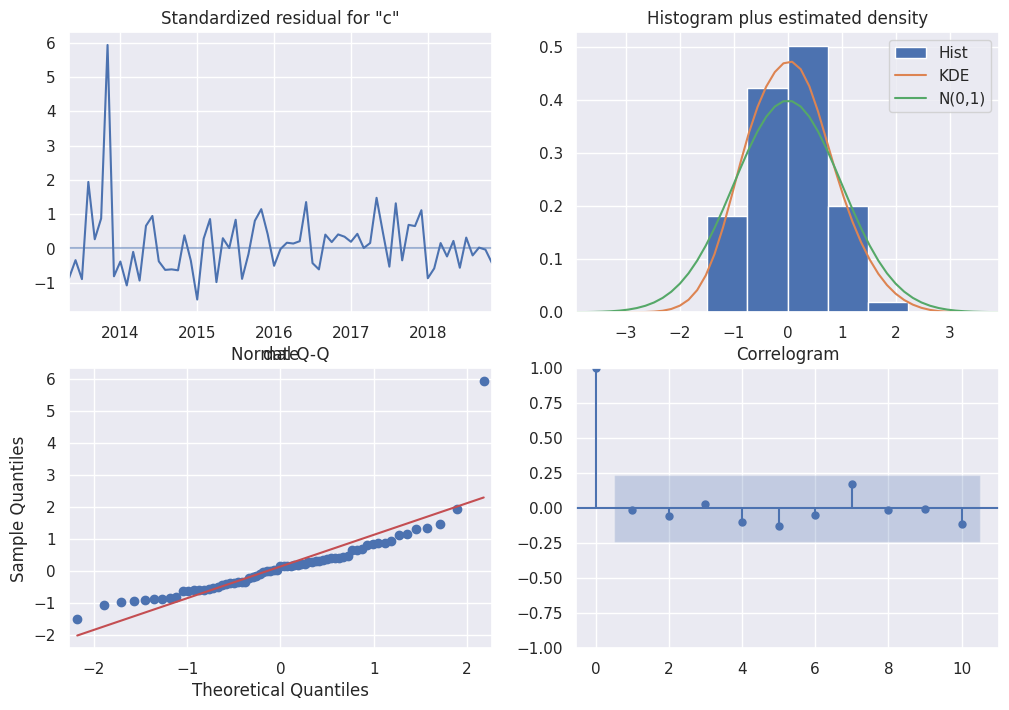

In [18]:
# Model diagnostics
print("\n## Model Diagnostics")
best_model.plot_diagnostics(figsize=(12, 8))
plt.show()

In [19]:
# Forecasting future values
print("\n## Forecasting")
future_dates = pd.date_range(start=btc_month.index[-1] + pd.Timedelta(days=1), periods=12, freq='M')
forecast = best_model.get_forecast(steps=12)
forecast_values = inverse_boxcox(forecast.predicted_mean, lmbda)
forecast_ci = forecast.conf_int()


## Forecasting


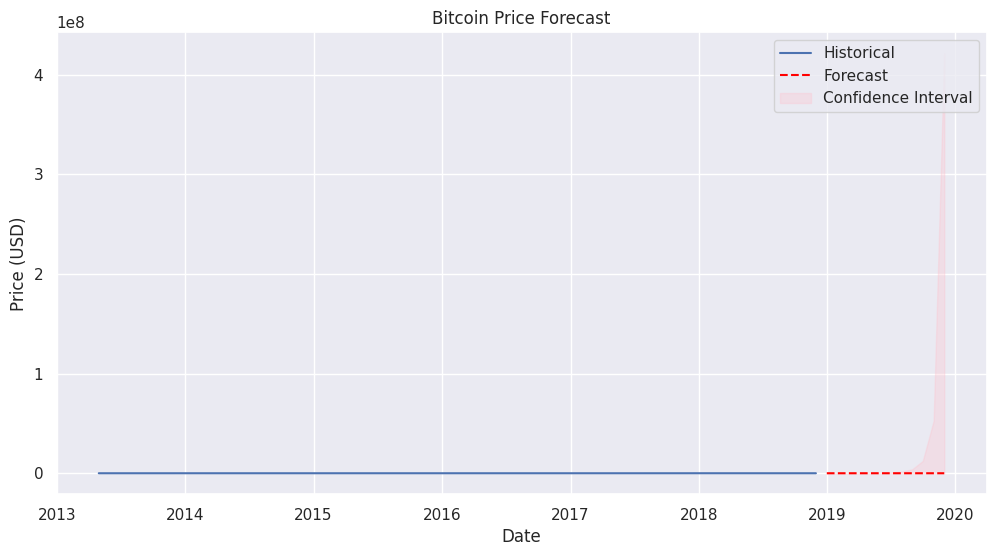

In [20]:
# Visualize forecast
plt.figure(figsize=(12, 6))
plt.plot(btc_month.index, inverse_boxcox(btc_month['close_box'], lmbda), label='Historical')
plt.plot(future_dates, forecast_values, label='Forecast', linestyle='--', color='red')
plt.fill_between(future_dates,
                 inverse_boxcox(forecast_ci.iloc[:, 0], lmbda),
                 inverse_boxcox(forecast_ci.iloc[:, 1], lmbda),
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()